In [99]:
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from sklearn.metrics import classification_report
from transformers import TOKENIZER_MAPPING, AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import os
from dataset import Dataset
import pandas as pd

In [100]:
TOKENIZER_NAME = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
MODEL_NAME = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
LEARNING_RATE = 3e-5

EPOCHS = 4
BATCH_SIZE = 24 
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())    
    print(f'We will use the GPU:{torch.cuda.get_device_name()} ({device})')

else:
    print('NO GPU AVAILABLE ERROR')
    device = torch.device("cpu")
   
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model = AutoModelForSequenceClassification.from_pretrained("../../task_a/pickles_tam/", num_labels=5, output_attentions=True)

model.to(device)
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, no_deprecation_warning=True)

data = Dataset()
_, _, _, _, _, _, datatrain, _ = data.get_phobia_dataset(tokenizer, balance=False)
#_,_, kan_train_2022, _, _,_ = data.get_fire_2022_dataset(tokenizer, balance=False)

train_dataloader = DataLoader(
            datatrain,
            sampler = RandomSampler(datatrain),
            batch_size = BATCH_SIZE)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


There are 2 GPU(s) available.
We will use the GPU:Tesla V100-SXM2-32GB (cuda)
Texts: 3128
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 790
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 1750
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 621
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 2521
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 837
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 3807
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 962
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')


In [103]:
def correlation_validation(model, tokenizer, device, BS=16):
    vbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))

    model.eval()
    
    true_labels = []
    pred_labels = []
    
    # Label names: Index(['Mixed_feelings', 'Negative', 'Positive', 'not-Tamil', 'unknown_state']
    # Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic']
    datalist = []
    for step, batch in vbar:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad(): 
            outputs = model(input_ids=b_input_ids, attention_mask=b_masks,
                                            labels=b_labels)
            
            logits = outputs.logits.detach().cpu().numpy().tolist()
            label_ids = b_labels.to('cpu').numpy().tolist()
            
            true_labels.extend(label_ids)
            
            for i in range(len(logits)):
                datalist.append([label_ids[i], logits[i][0], logits[i][1], logits[i][2], logits[i][3], logits[i][4]])
            
    model.train()
    return datalist

In [104]:
d = correlation_validation(model, tokenizer, device)

100%|██████████| 159/159 [00:37<00:00,  4.23it/s]


In [95]:
newpd = pd.DataFrame(d)
newpd

,0,1,2,3,4,5
0,1,-0.244377,4.256146,-1.875886,-1.758464,-1.138927
1,1,-1.050380,-1.492828,4.906031,-0.383150,-2.220087
2,1,-1.434588,-2.355056,4.702646,0.093078,-1.100863
3,1,-1.450472,-0.877995,3.174911,-0.891766,-0.271309
4,1,-0.346477,1.921342,0.165725,-3.512639,0.960543
...,...,...,...,...,...,...
957,1,-1.399992,0.415874,2.443807,-4.034671,1.627391
958,1,1.060619,-1.743320,3.796275,-3.460768,0.003241
959,1,-0.550741,1.052425,3.691472,-3.408550,-1.491923
960,1,-0.792785,-1.308054,4.466270,-0.196903,-2.434020


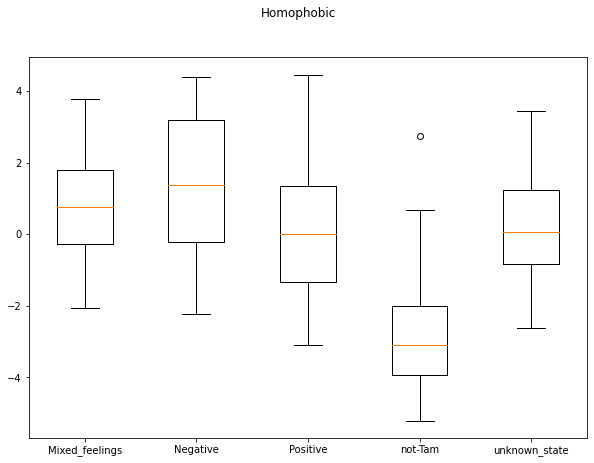

In [108]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot(newpd[newpd[0] == 0][[1,2,3,4,5]])
ax.set_xticklabels(['Mixed_feelings', 'Negative', 'Positive', 'not-Tam', 'unknown_state'])
fig.suptitle('Homophobic')
fig.savefig('../tam_figure/homophobic-sentiment.jpg')

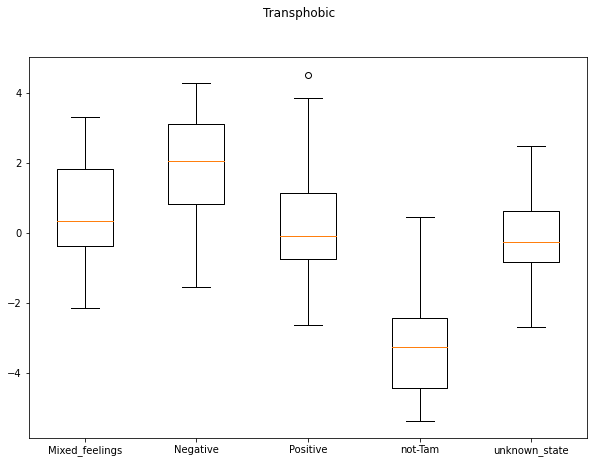

In [109]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot(newpd[newpd[0] == 2][[1,2,3,4,5]])
ax.set_xticklabels(['Mixed_feelings', 'Negative', 'Positive', 'not-Tam', 'unknown_state'])
fig.suptitle('Transphobic')
fig.savefig('../tam_figure/transphobic-sentiment.jpg')

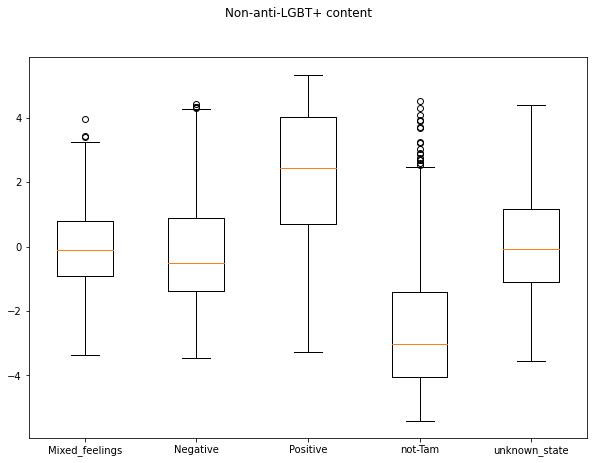

In [110]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot(newpd[newpd[0] == 1][[1,2,3,4,5]])
ax.set_xticklabels(['Mixed_feelings', 'Negative', 'Positive', 'not-Tam', 'unknown_state'])
fig.suptitle('Non-anti-LGBT+ content')
fig.savefig('../tam_figure/non-anti-LGBT+ content-sentiment.jpg')